In [1]:
import pandas as pd
df = pd.read_csv('dutch_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:58:56.606000,NOR,4,0 days 00:01:20.878000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:27.269000,...,True,McLaren,0 days 00:57:35.434000,2024-08-25 13:03:12.072,1,2.0,False,NaN,False,False
1,0 days 01:00:12.740000,NOR,4,0 days 00:01:16.134000,2.0,1.0,NaN,NaN,0 days 00:00:26.061000,0 days 00:00:27.155000,...,True,McLaren,0 days 00:58:56.606000,2024-08-25 13:04:33.244,1,2.0,False,NaN,False,True
2,0 days 01:01:29.236000,NOR,4,0 days 00:01:16.496000,3.0,1.0,NaN,NaN,0 days 00:00:25.995000,0 days 00:00:27.720000,...,True,McLaren,0 days 01:00:12.740000,2024-08-25 13:05:49.378,1,2.0,False,NaN,False,True
3,0 days 01:02:45.540000,NOR,4,0 days 00:01:16.304000,4.0,1.0,NaN,NaN,0 days 00:00:25.836000,0 days 00:00:27.683000,...,True,McLaren,0 days 01:01:29.236000,2024-08-25 13:07:05.874,1,2.0,False,NaN,False,True
4,0 days 01:04:01.811000,NOR,4,0 days 00:01:16.271000,5.0,1.0,NaN,NaN,0 days 00:00:25.816000,0 days 00:00:27.720000,...,True,McLaren,0 days 01:02:45.540000,2024-08-25 13:08:22.178,1,2.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,0 days 02:23:52.122000,ZHO,24,0 days 00:01:15.737000,66.0,3.0,NaN,NaN,0 days 00:00:25.857000,0 days 00:00:27.278000,...,True,Kick Sauber,0 days 02:22:36.385000,2024-08-25 14:28:13.023,1,20.0,False,NaN,False,True
1422,0 days 02:25:07.846000,ZHO,24,0 days 00:01:15.724000,67.0,3.0,NaN,NaN,0 days 00:00:25.746000,0 days 00:00:27.271000,...,True,Kick Sauber,0 days 02:23:52.122000,2024-08-25 14:29:28.760,1,20.0,False,NaN,False,True
1423,0 days 02:26:25.603000,ZHO,24,0 days 00:01:17.757000,68.0,3.0,NaN,NaN,0 days 00:00:26.736000,0 days 00:00:28.339000,...,True,Kick Sauber,0 days 02:25:07.846000,2024-08-25 14:30:44.484,1,20.0,False,NaN,False,True
1424,0 days 02:27:41.468000,ZHO,24,0 days 00:01:15.865000,69.0,3.0,NaN,NaN,0 days 00:00:25.980000,0 days 00:00:27.226000,...,True,Kick Sauber,0 days 02:26:25.603000,2024-08-25 14:32:02.241,1,20.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 72  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2              13.0          23.666667   
1    ALO              1              32.0          35.500000   
2    BOT              2              16.0          23.333333   
3    GAS              1              33.0          35.500000   
4    HAM              2              24.0          24.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.000000          0.408451         0.591549  
1          0.000000          0.436620         0.563380  
2          0.214286          0.385714         0.400000  
3          0.000000          0.450704         0.549296  
4          0.652778          0.000000         0.347222  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,12.0,0 days 01:13:20.361000,NaN,MEDIUM,12.0,1.0
1,ALB,13.0,NaN,0 days 01:13:41.643000,HARD,1.0,2.0
2,ALB,54.0,0 days 02:07:24.592000,NaN,HARD,42.0,2.0
3,ALB,55.0,NaN,0 days 02:07:45.541000,MEDIUM,1.0,3.0
4,ALO,31.0,0 days 01:37:43.488000,NaN,MEDIUM,31.0,1.0
5,ALO,32.0,NaN,0 days 01:38:04.767000,HARD,1.0,2.0
6,BOT,15.0,0 days 01:17:14.502000,NaN,SOFT,15.0,1.0
7,BOT,16.0,NaN,0 days 01:17:35.241000,HARD,1.0,2.0
8,BOT,43.0,0 days 01:53:36.263000,NaN,HARD,28.0,2.0
9,BOT,44.0,NaN,0 days 01:53:57.419000,MEDIUM,1.0,3.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,13.0,23.666667,0.000000,0.408451,0.591549
1,ALO,1,32.0,35.500000,0.000000,0.436620,0.563380
2,BOT,2,16.0,23.333333,0.214286,0.385714,0.400000
3,GAS,1,33.0,35.500000,0.000000,0.450704,0.549296
4,HAM,2,24.0,24.000000,0.652778,0.000000,0.347222
5,HUL,1,15.0,35.500000,0.000000,0.197183,0.802817
6,LEC,1,25.0,36.000000,0.000000,0.333333,0.666667
7,MAG,1,41.0,35.500000,0.000000,0.436620,0.563380
8,NOR,1,29.0,36.000000,0.000000,0.388889,0.611111
9,OCO,1,31.0,35.500000,0.000000,0.422535,0.577465


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1354


In [9]:
df['Driver'].value_counts()


,count
Driver,
NOR,69
VER,69
LEC,69
PIA,69
SAI,69
PER,69
ALO,68
GAS,68
HUL,68


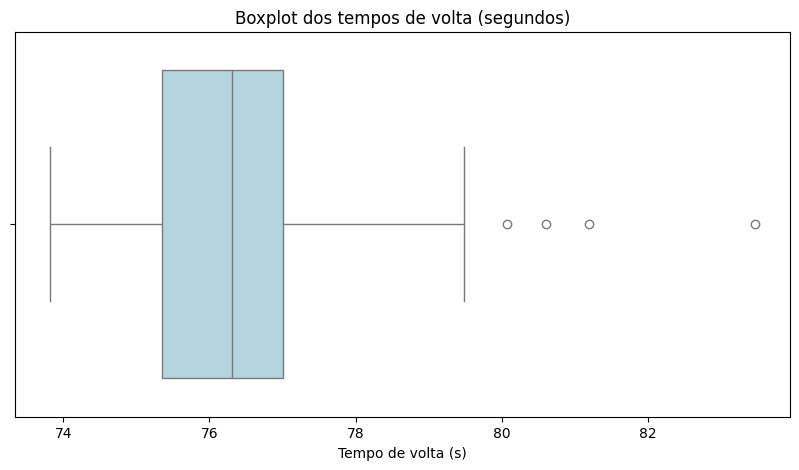

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


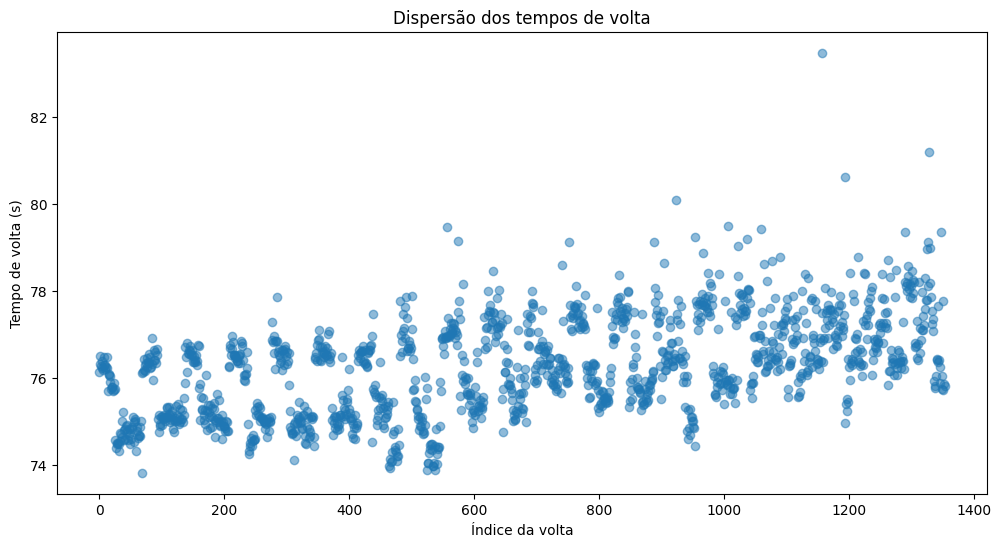

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


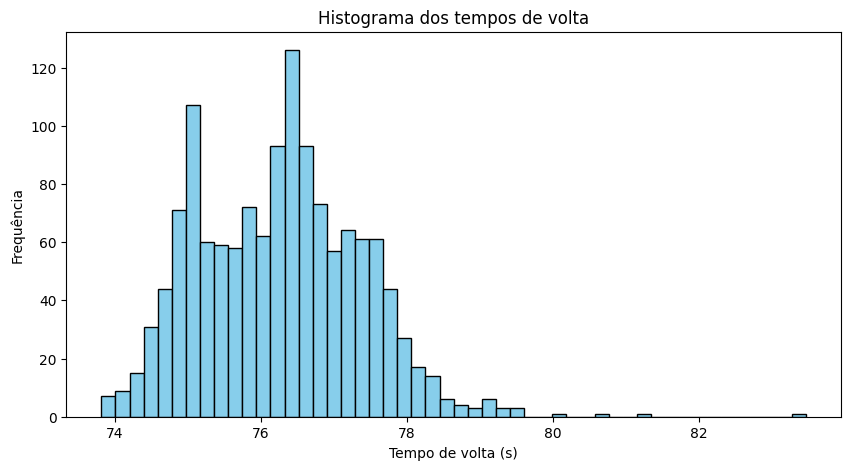

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


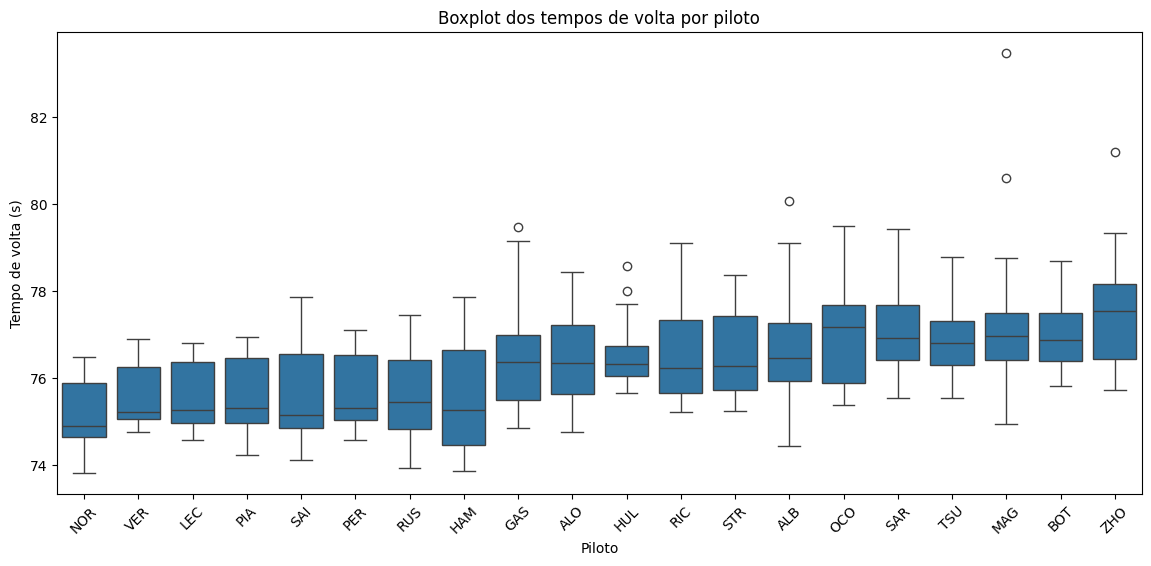

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
NOR   0 days 00:01:13.817000
HAM   0 days 00:01:13.878000
RUS   0 days 00:01:13.927000
SAI   0 days 00:01:14.117000
PIA   0 days 00:01:14.237000
ALB   0 days 00:01:14.434000
LEC   0 days 00:01:14.585000
PER   0 days 00:01:14.587000
VER   0 days 00:01:14.752000
ALO   0 days 00:01:14.758000
GAS   0 days 00:01:14.855000
MAG   0 days 00:01:14.954000
RIC   0 days 00:01:15.222000
STR   0 days 00:01:15.255000
OCO   0 days 00:01:15.390000
SAR   0 days 00:01:15.539000
TSU   0 days 00:01:15.552000
HUL   0 days 00:01:15.657000
ZHO   0 days 00:01:15.724000
BOT   0 days 00:01:15.822000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Holanda'
race_date = '2024-08-25'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,66,76.478212,1.108996,74.434,80.078,76.4530,5.644,2024,Holanda,2024-08-25
1,ALO,68,76.419750,0.942782,74.758,78.446,76.3530,3.688,2024,Holanda,2024-08-25
2,BOT,65,77.013631,0.718040,75.822,78.697,76.8820,2.875,2024,Holanda,2024-08-25
3,GAS,68,76.345603,0.977724,74.855,79.464,76.3825,4.609,2024,Holanda,2024-08-25
4,HAM,67,75.537761,1.189286,73.878,77.871,75.2620,3.993,2024,Holanda,2024-08-25
5,HUL,68,76.496426,0.619530,75.657,78.585,76.3175,2.928,2024,Holanda,2024-08-25
6,LEC,69,75.571739,0.711398,74.585,76.806,75.2770,2.221,2024,Holanda,2024-08-25
7,MAG,68,77.078353,1.164000,74.954,83.466,76.9700,8.512,2024,Holanda,2024-08-25
8,NOR,69,75.221014,0.726555,73.817,76.496,74.8920,2.679,2024,Holanda,2024-08-25
9,OCO,68,76.874574,1.050517,75.390,79.487,77.1695,4.097,2024,Holanda,2024-08-25


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,66,76.478212,1.108996,74.434,80.078,76.4530,5.644,2024,Holanda,2024-08-25,71.0,True
1,ALO,68,76.419750,0.942782,74.758,78.446,76.3530,3.688,2024,Holanda,2024-08-25,71.0,True
2,BOT,65,77.013631,0.718040,75.822,78.697,76.8820,2.875,2024,Holanda,2024-08-25,70.0,True
3,GAS,68,76.345603,0.977724,74.855,79.464,76.3825,4.609,2024,Holanda,2024-08-25,71.0,True
4,HAM,67,75.537761,1.189286,73.878,77.871,75.2620,3.993,2024,Holanda,2024-08-25,72.0,True
5,HUL,68,76.496426,0.619530,75.657,78.585,76.3175,2.928,2024,Holanda,2024-08-25,71.0,True
6,LEC,69,75.571739,0.711398,74.585,76.806,75.2770,2.221,2024,Holanda,2024-08-25,72.0,True
7,MAG,68,77.078353,1.164000,74.954,83.466,76.9700,8.512,2024,Holanda,2024-08-25,71.0,True
8,NOR,69,75.221014,0.726555,73.817,76.496,74.8920,2.679,2024,Holanda,2024-08-25,72.0,True
9,OCO,68,76.874574,1.050517,75.390,79.487,77.1695,4.097,2024,Holanda,2024-08-25,71.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,13.0,23.666667,0.000000,0.408451,0.591549
1,ALO,1,32.0,35.500000,0.000000,0.436620,0.563380
2,BOT,2,16.0,23.333333,0.214286,0.385714,0.400000
3,GAS,1,33.0,35.500000,0.000000,0.450704,0.549296
4,HAM,2,24.0,24.000000,0.652778,0.000000,0.347222
5,HUL,1,15.0,35.500000,0.000000,0.197183,0.802817
6,LEC,1,25.0,36.000000,0.000000,0.333333,0.666667
7,MAG,1,41.0,35.500000,0.000000,0.436620,0.563380
8,NOR,1,29.0,36.000000,0.000000,0.388889,0.611111
9,OCO,1,31.0,35.500000,0.000000,0.422535,0.577465


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,66,76.478212,1.108996,74.434,80.078,76.4530,5.644,2024,Holanda,2024-08-25,71.0,True,2,13.0,23.666667,0.000000,0.408451,0.591549
1,ALO,68,76.419750,0.942782,74.758,78.446,76.3530,3.688,2024,Holanda,2024-08-25,71.0,True,1,32.0,35.500000,0.000000,0.436620,0.563380
2,BOT,65,77.013631,0.718040,75.822,78.697,76.8820,2.875,2024,Holanda,2024-08-25,70.0,True,2,16.0,23.333333,0.214286,0.385714,0.400000
3,GAS,68,76.345603,0.977724,74.855,79.464,76.3825,4.609,2024,Holanda,2024-08-25,71.0,True,1,33.0,35.500000,0.000000,0.450704,0.549296
4,HAM,67,75.537761,1.189286,73.878,77.871,75.2620,3.993,2024,Holanda,2024-08-25,72.0,True,2,24.0,24.000000,0.652778,0.000000,0.347222
5,HUL,68,76.496426,0.619530,75.657,78.585,76.3175,2.928,2024,Holanda,2024-08-25,71.0,True,1,15.0,35.500000,0.000000,0.197183,0.802817
6,LEC,69,75.571739,0.711398,74.585,76.806,75.2770,2.221,2024,Holanda,2024-08-25,72.0,True,1,25.0,36.000000,0.000000,0.333333,0.666667
7,MAG,68,77.078353,1.164000,74.954,83.466,76.9700,8.512,2024,Holanda,2024-08-25,71.0,True,1,41.0,35.500000,0.000000,0.436620,0.563380
8,NOR,69,75.221014,0.726555,73.817,76.496,74.8920,2.679,2024,Holanda,2024-08-25,72.0,True,1,29.0,36.000000,0.000000,0.388889,0.611111
9,OCO,68,76.874574,1.050517,75.390,79.487,77.1695,4.097,2024,Holanda,2024-08-25,71.0,True,1,31.0,35.500000,0.000000,0.422535,0.577465


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoHolanda.csv', index=False)
